## Capstone - Speech Emotion Recognition 

Libraries imports

In [4]:
#pip install librosa soundfile numpy sklearn pyaudio

In [5]:
#pip install --upgrade tensorflow

In [1]:
# Import libraries 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [17]:
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# TESS = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
RAV = "../datasets/RAVDESS/audio_speech_actors_01-24/"
# SAVEE = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"
CREMA = "../datasets/AudioWAV/"

# Run one example 
dir_list = os.listdir(CREMA)
dir_list[0:5]

['1001_DFA_ANG_XX.wav',
 '1001_DFA_DIS_XX.wav',
 '1001_DFA_FEA_XX.wav',
 '1001_DFA_HAP_XX.wav',
 '1001_DFA_NEU_XX.wav']

### RAVDESS dataset

In [18]:
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

female_neutral     144
male_neutral       144
female_surprise     96
male_surprise       96
female_disgust      96
female_angry        96
female_happy        96
male_angry          96
male_disgust        96
male_fear           96
female_sad          96
female_fear         96
male_happy          96
male_sad            96
Name: labels, dtype: int64

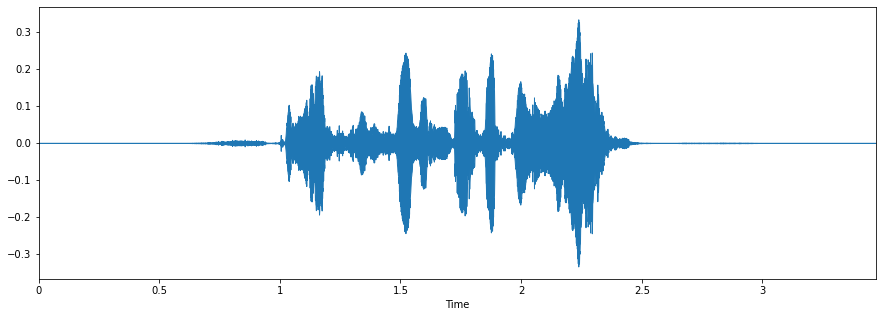

In [19]:
# Pick a fearful track
fname = RAV + 'Actor_14/03-01-06-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

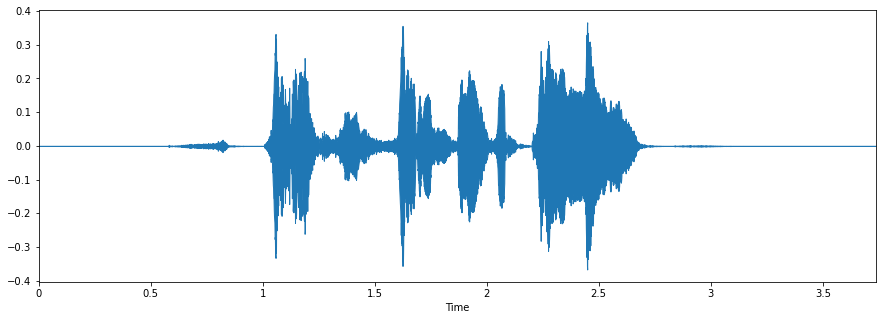

In [20]:
# Pick a happy track
fname = RAV + 'Actor_14/03-01-03-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

#### CREMA Dataset

In [10]:
dir_list = os.listdir(CREMA)
dir_list.sort()
print(dir_list[0:10])

['1001_DFA_ANG_XX.wav', '1001_DFA_DIS_XX.wav', '1001_DFA_FEA_XX.wav', '1001_DFA_HAP_XX.wav', '1001_DFA_NEU_XX.wav', '1001_DFA_SAD_XX.wav', '1001_IEO_ANG_HI.wav', '1001_IEO_ANG_LO.wav', '1001_IEO_ANG_MD.wav', '1001_IEO_DIS_HI.wav']


In [11]:
gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in dir_list: 
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA + i)
    
CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
CREMA_df.labels.value_counts()

male_angry        671
male_disgust      671
male_happy        671
male_sad          671
male_fear         671
female_sad        600
female_fear       600
female_disgust    600
female_angry      600
female_happy      600
male_neutral      575
female_neutral    512
Name: labels, dtype: int64

In [14]:
CREMA_df

,labels,source,path
0,male_angry,CREMA,../datasets/AudioWAV/1001_DFA_ANG_XX.wav
1,male_disgust,CREMA,../datasets/AudioWAV/1001_DFA_DIS_XX.wav
2,male_fear,CREMA,../datasets/AudioWAV/1001_DFA_FEA_XX.wav
3,male_happy,CREMA,../datasets/AudioWAV/1001_DFA_HAP_XX.wav
4,male_neutral,CREMA,../datasets/AudioWAV/1001_DFA_NEU_XX.wav
...,...,...,...
7437,female_disgust,CREMA,../datasets/AudioWAV/1091_WSI_DIS_XX.wav
7438,female_fear,CREMA,../datasets/AudioWAV/1091_WSI_FEA_XX.wav
7439,female_happy,CREMA,../datasets/AudioWAV/1091_WSI_HAP_XX.wav
7440,female_neutral,CREMA,../datasets/AudioWAV/1091_WSI_NEU_XX.wav


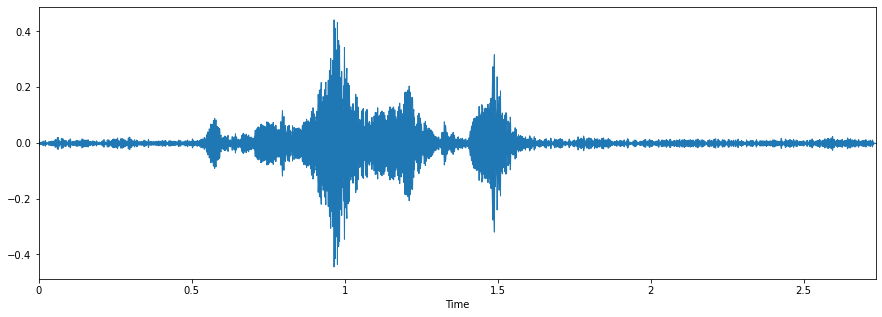

In [12]:
# use the well known Librosa library for this task 
fname = CREMA + '1012_IEO_HAP_HI.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

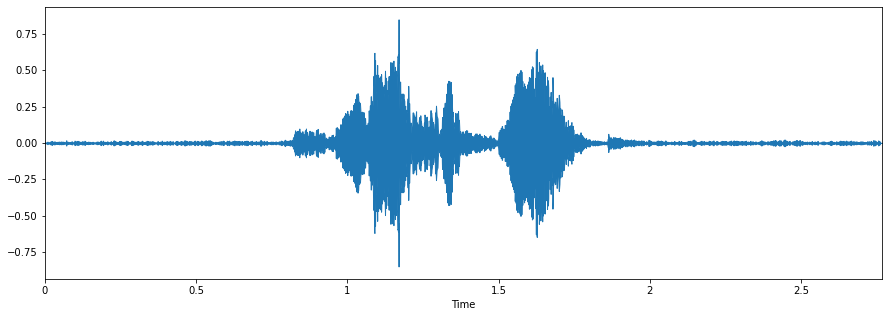

In [13]:
# A fearful track
fname = CREMA + '1012_IEO_FEA_HI.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

In [21]:
df = pd.concat([RAV_df, CREMA_df], axis = 0)
print(df.labels.value_counts())
df.head()
df.to_csv("../datasets/data_path.csv",index=False)

male_angry         767
male_disgust       767
male_happy         767
male_sad           767
male_fear          767
male_neutral       719
female_sad         696
female_fear        696
female_disgust     696
female_angry       696
female_happy       696
female_neutral     656
female_surprise     96
male_surprise       96
Name: labels, dtype: int64
